# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 1. Метрики и меры схожести.**

Смена рабочей директории.

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/2023-Berezin-TimeSeriesCourse-main.zip', 'r') as f:
  f.extractall('/content/drive/MyDrive')

In [ ]:
import os
os.chdir('/content/drive/MyDrive/2023-Berezin-TimeSeriesCourse-main/practice/01 Basics')

Использование команд, которые автоматически перезагружают все импортированные модули при их изменении.

In [ ]:
%load_ext autoreload
%autoreload 2

## **Часть 1.** Евклидова метрика и DTW мера. Матрица расстояний. Иерархическая кластеризация.

Импорт библиотек и модулей.

In [ ]:
import numpy as np
import pandas as pd
import modules

from modules.metrics import *
from modules.utils import *
from modules.plots import *
from modules.clustering import *

### **Задача 1.**
Вам необходимо самостоятельно реализовать функцию `ED_distance()` в модуле *metrics.py* для нахождения евклидовой метрики между временными рядами, имеющими одинаковую длину, и проверить ее реализацию с помощью функции `euclidean_distance()` из библиотеки *sktime*. В качестве входных данных используйте два синтетических временных ряда некоторой заданной вами длины, сгенерированных моделью случайных блужданий (Random Walk). Модель случайных блужданий реализуйте самостоятельно или используйте готовые реализации.

*Евклидова метрика* между временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
    \text{ED}(T_1, T_2) = \sqrt{\sum_{i=1}^{n} ({t_{1}}_i-{t_{2}}_i)^2}.
\end{equation}

In [ ]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 16.2 MB/s eta 0:00:00


In [ ]:
from sktime.distances import euclidean_distance
import random
from modules.metrics import ED_distance

def test_ed_distance(ts1, ts2):

    sktime_ed_dist = round(euclidean_distance(ts1, ts2), 5)
    desired_ed_dist = round(ED_distance(ts1, ts2), 5)

    np.testing.assert_equal(sktime_ed_dist, desired_ed_dist, 'ED distances are not equal')

In [ ]:
# Создаем два синтетических временных ряда
length = 10
np.random.seed(42)
ts1 = np.cumsum(np.random.randn(length))
ts2 = np.cumsum(np.random.randn(length))

test_ed_distance(ts1, ts2)

### **Задача 2.**

Вам необходимо самостоятельно реализовать функцию `DTW_distance()` в модуле *metrics.py* для нахождения DTW меры между временными рядами, имеющими одинаковую длину, и проверить ее реализацию с помощью функции `dtw_distance()` из библиотеки *sktime*. Сгенерируйте два временных ряда некоторой заданной вами длины с помощью модели случайных блужданий (Random Walk) или используйте ряды из предыдущей задачи.

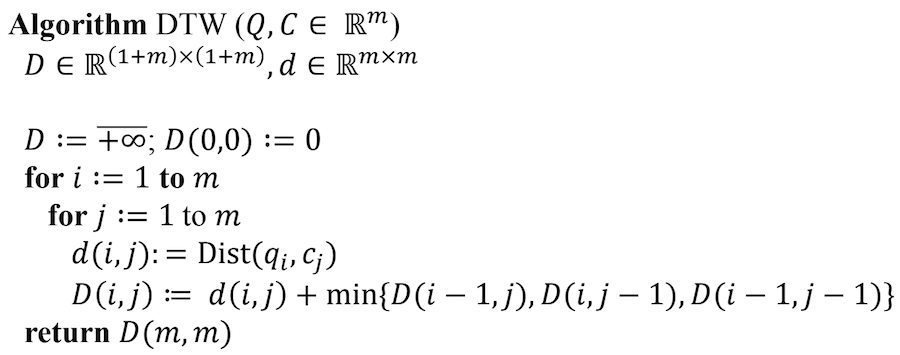

In [ ]:
import random
from sktime.distances import dtw_distance
from modules.metrics import DTW_distance

def test_dtw_distance(ts1, ts2):

    sktime_dtw_dist = dtw_distance(ts1, ts2)
    desired_dtw_dist = DTW_distance(ts1, ts2)

    np.testing.assert_equal(sktime_dtw_dist, desired_dtw_dist, 'DTW distances are not equal')

In [ ]:
# Создаем два синтетических временных ряда
length = 10
np.random.seed(42)
ts1 = np.cumsum(np.random.randn(length))
ts2 = np.cumsum(np.random.randn(length))

test_dtw_distance(ts1, ts2)

### **Задача 3.**
Реализуйте функцию нахождения матрицы расстояния между временными рядами. Для вычисления расстояний между рядами используйте реализованные вами функции `ED_distance()` и `DTW_distance()` из модуля *metrics.py*.

Поскольку евклидова метрика и DTW мера удовлетворяют аксиоме симметричности (т.е. $dist(A,B)=dist(B,A)$), то матрица расстояний будет квадратной и симметричной относительно главной диагонали. Для ускорения вычислений достаточно найти ее верхний треугольник, а нижний треугольник матрицы заполнить значениями верхнего треугольника следующим образом: $dist\_matrix(j,i) = dist\_matrix(i,j)$, где $i < j$.

In [ ]:
def calculate_distance_matrix(data, metric='euclidean'):
    N = data.shape[0]  # number of time series
    distance_matrix = np.zeros(shape=(N, N))

    for i in range(N):
        for j in range(i + 1, N):
            if metric == 'euclidean':
                distance = ED_distance(data[i], data[j])
            elif metric == 'dtw':
                distance = DTW_distance(data[i], data[j])
            else:
                raise ValueError("Unsupported distance metric")

            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance

    return distance_matrix

### **Задача 4.**
Далее рассмотрим задачу иерархической кластеризации временных рядов, где будет использоваться вычисленная матрица расстояний.

Для этого сначала загрузите набор временных рядов CBF из файла CBF_TRAIN.txt. Каждая строка данного файла содержит целевую переменную (класс: 0, 1 или 2), которая записана в первом столбце, и временной ряд -- в остальных столбцах. Набор CBF является синтетическим и включает в себя 30 временных рядов,  каждый из которых принадлежит к одному из трех классов.

In [ ]:
def load_ts(file_name):

    ts = pd.read_csv(file_name, header=None, delim_whitespace=True)

    return ts

In [ ]:
url = './datasets/part1/CBF_TRAIN.txt'

data = load_ts(url)

ts_set = data.iloc[:, 1:].to_numpy()
labels = data.iloc[:, 0].squeeze().to_numpy()

Выполните визуализацию экземпляра каждого класса. Для этого используйте функцию `plot_ts_set()` из модуля *plots.py*.

In [ ]:
from modules.plots import plot_ts_set
plot_ts_set(ts_set)

Далее вам необходимо самостоятельно реализовать класс для выполнения иерархической кластеризации временных рядов.

Перед тем как приступить к его реализации, изучите скелет класса `TimeSeriesHierarchicalClustering`, который представлен в модуле *clustering.py*. Реализуйте метод `fit()`, выполняющий кластеризацию данных на основе предвычисленной матрицы расстояний, которая передается в данный метод. Поскольку реализовать иерархическую кластеризацию довольно сложно, используйте готовую реализацию AgglomerativeClustering из *sklearn*.   

Протестируйте свою реализацию иерархической кластеризации на наборе данных CBF для двух метрик: евлидовой метрики и DTW меры.
Для этого сначала найдите матрицы расстояний между временными рядами и передайте их в метод `fit()` для кластеризации.
Далее выполните визуализацию результатов в виде дендрограмм с помощью метода `plot_dendrogram()`, передав исходный набор временных рядов и их метки.

In [ ]:
euclidean_distance_matrix = calculate_distance_matrix(ts_set, metric='euclidean')

In [ ]:
clustering_euclidean = TimeSeriesHierarchicalClustering(n_clusters=3, method='complete')
clustering_euclidean.fit(euclidean_distance_matrix)

clustering_euclidean.plot_dendrogram(ts_set, labels)

In [ ]:
dtw_distance_matrix = calculate_distance_matrix(ts_set, metric='dtw')

In [ ]:
clustering_dtw = TimeSeriesHierarchicalClustering(n_clusters=3, method='complete')
clustering_dtw.fit(dtw_distance_matrix)

clustering_dtw.plot_dendrogram(ts_set, labels)

**Метрика Евклида:**

Преимущества: Метрика Евклида хорошо работает, когда форма и амплитуда временных рядов сильно коррелируют. Она быстро рассчитывается и может быть полезной для простых временных рядов с небольшими шумами.
Недостатки: Она чувствительна к сдвигам и масштабированию временных рядов, и не учитывает нелинейные зависимости между точками данных. Если временные ряды имеют сильные нелинейности, то метрика Евклида может давать менее устойчивые результаты.

**Мера DTW (Dynamic Time Warping):**

Преимущества: Мера DTW более гибкая и способна учитывать различные сдвиги и искажения между временными рядами. Это делает ее более подходящей для временных рядов с разными скоростями изменения и нелинейными зависимостями. Она может обрабатывать временные ряды с разной длиной.
Недостатки: Рассчет DTW может быть более вычислительно затратным и требовать больше ресурсов, чем метрика Евклида. Она может не работать хорошо для временных рядов с простыми и линейными зависимостями.

**Выбор между метрикой Евклида и DTW зависит от природы данных и цели кластеризации:**

Если временные ряды имеют простую и линейную структуру, метрика Евклида может дать хорошие результаты и будет вычислительно более эффективной.
Если есть нелинейные зависимости, различные скорости изменения и искажения между временными рядами, то мера DTW может быть более подходящей, хотя она может потребовать больше времени на рассчет.